In [28]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import sympy as sp
from sympy import symbols, Add, Mul
from sympy.core import Basic
import time 
import numbers   

In [29]:
def SOS(p, degree, n_var):
    
    # p : Coefficients of polynomial in increasing order of degree
    # n : No of variable
    
    half_degree = int(degree/2)
    len_mono = int(sci.special.comb(n_var+degree,degree)) # (n+d)Cd
    
    if(isinstance(p, list)):
        if(len(p)==0):
            p = cp.Variable(len_mono)
    

    # Creating constraints for SOS polynomial


    # Create matrix of coefficients

    Q = cp.Variable((half_degree+1,half_degree+1))

    constraint = [Q>>0]  # Semidefinite

    for k in range(0,len_mono):
        sum = 0
        for i in range(0,k+1,1):
            if((i<half_degree+1) & (k-i<half_degree+1)):
                sum+=Q[i,k-i]
        constraint+=[sum == p[k]]

    return p,Q,constraint

def multiply_polynomials(A, B):
    
    # The result of multiplication will have degree (len(A) + len(B) - 2)
    na = len(A)
    if(isinstance(B, list)):
        nb = len(B)
    else:
        nb = B.shape[0]

    result_length = na + nb - 1
    result = []
    
    # Perform the polynomial multiplication
    for i in range(na):
        for j in range(nb):
            if i + j < len(result):
                result[i + j] += A[i] * B[j]
            else:
                # If the index exceeds current list length, append a coeffient
                result.append(A[i] * B[j])
    
    return result

def SOS_multi(p, degree, n_var):
    
    # p : Coefficients of polynomial in increasing order of degree
    # n : No of variable
    
    half_degree = int(degree/2)
    len_mono = int(sci.special.comb(n_var+degree,degree))
        

    # Creating constraints for SOS polynomial


    # Create matrix of coefficients

    def split_monomial(term, basis):
        term_poly = sp.Poly(term, x, y)
        term_dict = term_poly.as_expr().as_coefficients_dict()
        
        split = []
        # Iterate through all possible pairs in the basis
        for i, m1 in enumerate(basis):
            for j, m2 in enumerate(basis[i:], start=i):
                product = m1 * m2
                product_poly = sp.Poly(product, x, y)
                product_dict = product_poly.as_expr().as_coefficients_dict()
                
                if product_dict == term_dict:
                    split.append((m1, m2))

        if len(split)==0:            
            raise ValueError(f"No valid split for {term} in the given basis.")
        return split

    terms = []
    for k in range(degree + 1):
        for i in range(k + 1):
            j = k - i
            terms.append(x**i * y**j)
    
    half_terms = []
    for k in range(half_degree + 1):
        for j in range(k + 1):
            i = k - j
            half_terms.append(x**i * y**j)


    size = len(half_terms) 
    Q = cp.Variable((size, size), symmetric=True)
    constraint = [Q>>0]

    for poly_ind,term in enumerate(terms):
        # Split term into monomial components (e.g., x^2y^2 → (x^2, y^2))
        monomial_list = split_monomial(term, half_terms)  
        sum = 0
        for m1, m2 in monomial_list:
            idx_i = half_terms.index(m1)
            idx_j = half_terms.index(m2)
            if idx_i == idx_j:
                sum += Q[idx_i, idx_j] 
            else:
                sum += Q[idx_i, idx_j] + Q[idx_j, idx_i]
    
        constraint+=[sum == p[poly_ind]]

    return p,Q,constraint

def extract_coeff(polynomial, d):
    x, y = sp.symbols('x y')
    # Generate all monomial terms x^i y^j where i + j <= d
    terms = []
    for k in range(d + 1):
        for j in range(k + 1):
            i = k - j
            terms.append(x**i * y**j)
    # Extract coefficients with zero preservation
    
    result = [sp.Poly(polynomial, x, y).coeff_monomial(term) for term in terms]

    return result

def Solver(objective,constraint,solver = cp.SCS):

    problem = cp.Problem(objective, constraint) # Define the problem

    init =time.time()

    if solver == cp.SCS:
        problem.solve(solver=solver,max_iters=int(1e7), eps=1e-7)
    elif solver == cp.CLARABEL:
        problem.solve(solver=solver, max_iter = int(1e7), tol_feas = 1e-9)
                            
    final = time.time()

    print('Size of problem : ', problem.size_metrics.num_scalar_data)
    print('Solver used : ',problem.solver_stats.solver_name) 
    print("Is the solution optimal : ", problem.status)   
    print('Time required by solver to setup the problem :',problem.solver_stats.setup_time,'s')
    print('Number of iterations :',problem.solver_stats.num_iters)
    print('Time required by solver to solve the problem :',problem.solver_stats.solve_time,'s')
    print("Optimal cost :", problem.value)

# SOS programming
Univariate polynomial can be written as sum of squares. To find the minimum value of a polynomial $p(x)$, we formulate it as a SDP optimization
$$
\begin{aligned}
\text{maximize} \quad & \gamma \\
\text{subject to} \quad & p(x) - \gamma \geq 0 \Leftrightarrow p(x) - \gamma = [x]_d^TQ[x]_d \quad \forall x \\
Q \succeq 0
\end{aligned}
$$

In [30]:
def SOS_minimization(p,degree,n_var):
    gamma = cp.Variable()
    p_coeff = p.copy()
    p_coeff[0]-=gamma
    _,Q,constraint = SOS(p_coeff,degree,n_var)
    
    objective = cp.Maximize(gamma)
    Solver(objective,constraint)
    print("Optimal gamma:",gamma.value)
    print("Optimal Q:",'\n', Q.value)

In [31]:
def SOS_interval_min(p,a,b,degree,n_var):
    gamma = cp.Variable()
    p_coeff = p.copy()
    p_coeff[0]-=gamma
    p_s2,Q_s2,constraint_s2 = SOS([],degree-2,n_var)

    xa = [-a,1]
    xb = [b,-1]
    res_xa_xb = multiply_polynomials(xa, xb)
    res_p_s2 = multiply_polynomials(res_xa_xb,p_s2)
    
    s1 = [x - y for x, y in zip(p_coeff, res_p_s2)]

    p_s1,Q_s1,constraint_s1 = SOS(s1,degree,n_var)
    objective = cp.Maximize(gamma)
    constraint = constraint_s1+constraint_s2
    Solver(objective,constraint)
    
    print("Optimal gamma:",gamma.value)
    print("Optimal ps2:", p_s2.value)

In [32]:
p  = [-5,5,1,2,1]
a = -1
b = 2
SOS_minimization(p, degree = 4, n_var = 1)

Size of problem :  6
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000110263 s
Number of iterations : 225
Time required by solver to solve the problem : 0.0012623930000000001 s
Optimal cost : -12.099892072788217
Optimal gamma: -12.099892072788217
Optimal Q: 
 [[ 7.09989207  2.5        -1.08276326]
 [ 2.5         3.16552654  0.99999999]
 [-1.08276328  1.00000001  1.        ]]


To find minimum of $p(x)$ in a interval $[a,b]$, we formulate the SDP optimization as 
$$
\begin{aligned}
\text{maximize} \quad & \gamma \\
\text{subject to} \quad & s(x) \in SOS \\
&p(x) - \gamma - (x-a)(b-x)s(x) \in SOS \quad if \ deg(p(x)) \text{ is even}\\ 

\end{aligned}
$$

In [33]:
SOS_interval_min(p, a, b, degree = 4, n_var = 1)

Size of problem :  16
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000125172 s
Number of iterations : 100
Time required by solver to solve the problem : 0.0008434390000000001 s
Optimal cost : -9.999999994399568
Optimal gamma: -9.999999994399568
Optimal ps2: [1.46832572 1.09252257 1.29086351]


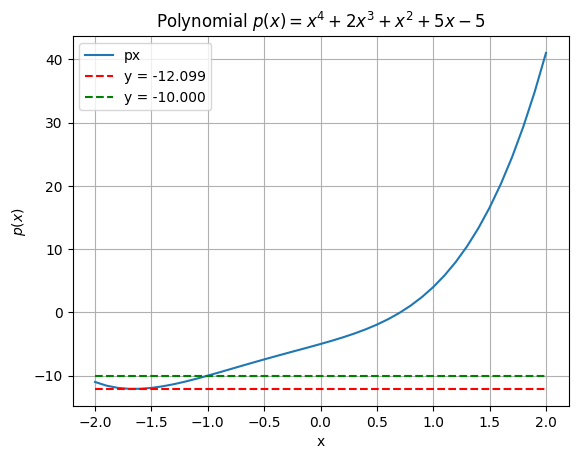

In [34]:
x = np.arange(-2, 2+0.1, 0.1)
px = 0
for i,p_el in enumerate(p):
    px +=p_el*x**i

plt.plot(x, px, label='px')  # Solid line for px
plt.plot(x, -12.099892072788217 * np.ones(x.shape), '--', label='y = -12.099', color='red')  # Dotted line
plt.plot(x, -10.000001763695249 * np.ones(x.shape), '--', label='y = -10.000', color='green')  # Dotted line

plt.legend()
plt.xlabel('x')
plt.ylabel('$p(x)$')
plt.title('Polynomial $p(x) = x^4+2x^3+x^2+5x-5$')
plt.grid()

# Problem 3 : Multivariate SOS polynomials

In the case of multivariate polynomial, non negative polynomials may not be written in terms of sum of square polynomial. But in the case of bivariate quadratics (n = 2, 2d = 4), we can write it as sum of square polynomial. For other types of polynomial, non negative polynomial need not be sum of squares polynomial. 

Example : Motzkin polynomial - $M(x,y) = x^4y^2+x^2y^4+1-3x^2y^2$. This polynomial cannot be written as sum of squares. If we try to solve $M(x,y) - \gamma \in SOS$ as optimization problem to find the minimum of $M(x,y)$ like we did for univariate case, we can see that no $\gamma$ exist.

In [35]:
deg = 6
n = 2
length = sci.special.comb(deg+n,deg)
m = np.zeros(int(length)) # 1 − 3x2y2 + x4y2 + x2y4  
m[0] = 1
m[12] = -3
m[23] = 1
m[25] = 1 
m = m.tolist()

q = np.zeros(int(length)) # 1 + y2 + x2  
q[0] = 1
q[3] = 1
q[5] = 1 
q = q.tolist()

x , y = sp.symbols('x y')
poly1 = 1 - 3*x**2*y**2 + x**4*y**2 + x**2*y**4
poly2 = 1 + x**2  + y**2


'''
1 x^0y^0 *
2 x^1y^0
3 x^0y^1
4 x^2y^0
5 x^1y^1
6 x^0y^2
7 x^3y^0
8 x^2y^1
9 x^1y^2
10 x^0y^3
11 x^4y^0
12 x^3y^1
13 x^2y^2 *
14 x^1y^3
15 x^0y^4
16 x^5y^0
17 x^4y^1
18 x^3y^2
19 x^2y^3
20 x^1y^4
21 x^0y^5
22 x^6y^0
23 x^5y^1
24 x^4y^2 *
25 x^3y^3
26 x^2y^4 *
27 x^1y^5
28 x^0y^6
'''

# extract_coeff : [1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5, x**6, x**5*y, x**4*y**2, x**3*y**3, x**2*y**4, x*y**5, y**6]
# Polynomial list : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

'\n1 x^0y^0 *\n2 x^1y^0\n3 x^0y^1\n4 x^2y^0\n5 x^1y^1\n6 x^0y^2\n7 x^3y^0\n8 x^2y^1\n9 x^1y^2\n10 x^0y^3\n11 x^4y^0\n12 x^3y^1\n13 x^2y^2 *\n14 x^1y^3\n15 x^0y^4\n16 x^5y^0\n17 x^4y^1\n18 x^3y^2\n19 x^2y^3\n20 x^1y^4\n21 x^0y^5\n22 x^6y^0\n23 x^5y^1\n24 x^4y^2 *\n25 x^3y^3\n26 x^2y^4 *\n27 x^1y^5\n28 x^0y^6\n'

In [36]:
def SOS_multi_min(p,degree,n_var, solver = cp.SCS):
    gamma = cp.Variable()

    p_vec = extract_coeff(p,degree)
    p_vec[0]-=gamma
    _,Q,constraint = SOS_multi(p_vec,degree,n_var)
    
    objective = cp.Maximize(gamma)
     
    Solver(objective,constraint,solver)
    
    print("Optimal gamma:",gamma.value)
    #print("Optimal Q:", Q.value)

In [37]:
SOS_multi_min(poly1, degree = 6, n_var = 2, solver = cp.CLARABEL)

Size of problem :  29
Solver used :  CLARABEL
Is the solution optimal :  optimal_inaccurate
Time required by solver to setup the problem : None s
Number of iterations : 12791
Time required by solver to solve the problem : 3.423264178 s
Optimal cost : -1703.660407461297
Optimal gamma: -1703.660407461297


/home/arivoli/Python/py_3_12_3/install_module_venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Hierarchy SOS relaxation

Using the Hilbert - Artin's theorem : If $p(x)$ is non-negative polynomial, then there exist non zero SOS polynomials $h(x) \ \text{and} \ q(x)$ such that 
$$h(x)p(x) = q(x)$$
It means, if we multiply a SOS polynomial $h(x)$ to a non-negative polynomial $p(x)$, we get a SOS polynomial $q(x) = h(x)p(x)$. Using this we can formulate the minimization of polynomial 

$$
\begin{aligned}
\text{maximize} \quad & \gamma \\
\text{subject to} \quad & (1+x^2+y^2)(M(x,y)-\gamma) \in SOS \\
\end{aligned}
$$

In [38]:
def SOS_multi_formulate(p,q,degree,n_var,solver = cp.SCS):
    gamma = cp.Variable()

    res = p*q
    r_vec = extract_coeff(res,degree*2)
    q_vec = extract_coeff(q,degree*2)
    
    r_coeff = [x - gamma*y for x, y in zip(r_vec, q_vec)]

    p_res,Q_res,constraint = SOS_multi(r_coeff,2*degree,n_var)

    objective = cp.Maximize(gamma)
     
    Solver(objective,constraint,solver)
    
    print("Optimal gamma:",gamma.value)
    #print("Optimal Q_res:", Q_res.value)

In [39]:
SOS_multi_formulate(poly1, poly2, degree = 6, n_var = 2, solver = cp.CLARABEL)

Size of problem :  183
Solver used :  CLARABEL
Is the solution optimal :  optimal
Time required by solver to setup the problem : None s
Number of iterations : 17
Time required by solver to solve the problem : 0.342510668 s
Optimal cost : 2.0292412200409237e-10
Optimal gamma: 2.0292412200409237e-10


In [64]:
def get_monomial(d):
    x, y = sp.symbols('x y')
    # Generate all monomial terms x^i y^j where i + j <= d
    terms = []
    for k in range(d + 1):
        for j in range(k + 1):
            i = k - j
            terms.append(x**i * y**j)
    return terms

print(get_monomial(4))
print(get_monomial(6))

[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4]
[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5, x**6, x**5*y, x**4*y**2, x**3*y**3, x**2*y**4, x*y**5, y**6]


In [65]:
def create_new_coeff_list_x_y(original_coeff, r, mult):
    # Calculate total terms in new polynomial: (r+1)(r+2)/2 r - degree of old polynomial
    new_length = (r+2 + 1) * (r+2 + 2) // 2
    new_coeff_list =  [0]* new_length
    
    pos = 0  # Position in original_coeff list
    
    for k in range(r + 1):  # Iterate through monomial of original polynomial
        for i in range(k + 1):  # For each term (i, j) where i + j = k
            # Calculate new term's index after x^2/y^2 multiplication
            m = k + 2  # New total degree after multiplying by x^2/y^2
            if(mult=='x'):
                new_index = m * (m + 1) // 2 + (i)
            elif(mult=='y'):
                new_index = m * (m + 1) // 2 + (i + 2)
            
            if new_index < new_length:
                new_coeff_list[new_index] = original_coeff[pos]
            pos += 1
    
    return new_coeff_list

## Putinar Positivstellensatz

For the constrained Motzkin polynomial minimization, we use Putinar Positivstellensatz to formulate it into SDP 
$$
\begin{aligned}
\text{maximize} \quad & \gamma \\
\text{subject to} \quad & s_1(x), s_2(x) \in SOS_d, SOS_{d-2} \\
&p(x) - \gamma = s_1(x)+(2-x^2-y^2)s_2(x) \quad (x^2+y^2 \leq 2)\\ 
\end{aligned}
$$

For various degree d of the SOS polynomial we get better solution from the hierarchy optimization

In [77]:
def SOS_heirachy(p,r,degree,n_var, c = 2):
    gamma = cp.Variable()
    x,y = sp.symbols('x y')
    length = int(sci.special.comb(n_var+r-2,r-2))
    length_new = int(sci.special.comb(n_var+r,r))
    p_s2 = cp.Variable(length)
    _,Q_s2,constraint_s2 = SOS_multi(p_s2,r-2,n_var)


    p_new = [0]*length_new  # After multiplication of (c-x^2-y^2)s2(x,y)
    p_new[:length] = c*p_s2 # For multiplication of 'c'
    prod_x = create_new_coeff_list_x_y(p_s2, r-2, 'x')  # For multiplication of x2
    prod_y = create_new_coeff_list_x_y(p_s2, r-2, 'y')  # For multiplication of y2

    prod = [x - y -z for x, y, z in zip(p_new, prod_x, prod_y)]

    p_coeff = extract_coeff(p,r)
    p_coeff[0]-=gamma
    s1 = [x - y for x, y in zip(p_coeff, prod)]

    p_s1,Q_s1,constraint_s1 = SOS_multi(s1,r,n_var)
    objective = cp.Maximize(gamma)
    constraint = constraint_s1+constraint_s2
    Solver(objective,constraint)
    
    print("Optimal gamma:",gamma.value)
    print("Optimal ps2:", p_s2.value)

In [78]:
SOS_heirachy(poly1,6,6,2, c = 2)

Size of problem :  66
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000291408 s
Number of iterations : 425
Time required by solver to solve the problem : 0.013761409 s
Optimal cost : -6.725805923565332e-08
Optimal gamma: -6.725805923565332e-08
Optimal ps2: [ 3.08961928e-01 -7.60575637e-15 -2.89473703e-14 -3.09865407e-01
  7.77169464e-13 -3.09865407e-01  8.54596790e-13  3.38245924e-13
 -8.47146238e-13 -3.08934148e-13  4.33997583e-01 -6.55427658e-13
 -5.57223809e-01 -1.24441714e-13  4.33997583e-01]


In [79]:
SOS_heirachy(poly1,8,6,2, c = 2)

Size of problem :  95
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000438291 s
Number of iterations : 375
Time required by solver to solve the problem : 0.029029658 s
Optimal cost : 2.397113716329514e-08
Optimal gamma: 2.397113716329514e-08
Optimal ps2: [ 3.79317528e-01 -2.33178307e-16 -8.57305985e-15  6.11426431e-02
 -2.72971729e-15  6.11426431e-02 -9.82042133e-15  2.74686056e-15
 -9.83274729e-16  6.68592797e-16  1.00829984e-01  3.27134339e-14
 -1.59415545e+00 -3.09530074e-14  1.00829984e-01 -4.18419066e-16
  4.93217325e-16  1.85705643e-14  1.80773260e-14 -6.44692127e-15
 -1.38810315e-14  2.91021423e-01 -3.30939300e-14  1.54435015e-01
  1.99228646e-14  1.54435015e-01  1.70329393e-14  2.91021423e-01]


In [80]:
SOS_heirachy(poly1,10,6,2, c = 2)

Size of problem :  128
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.001004147 s
Number of iterations : 1050
Time required by solver to solve the problem : 0.15935965500000002 s
Optimal cost : 1.0659189454307765e-07
Optimal gamma: 1.0659189454307765e-07
Optimal ps2: [ 4.14746992e-01 -1.48965868e-15  4.02567560e-14  1.49214401e-01
 -1.42340170e-14  1.49214401e-01 -4.28962847e-15 -1.99029005e-14
  8.46619153e-15  2.00101475e-14  1.73992334e-02  3.54794776e-14
 -1.29405827e+00  3.51292228e-15  1.73992334e-02  6.79843160e-15
 -1.93842760e-14 -1.73898021e-14 -1.05550766e-14 -6.05675172e-15
  7.78534276e-15  1.40336814e-01  2.22085729e-14 -1.62803993e-01
 -5.66505938e-14 -1.62803993e-01  1.35487894e-15  1.40336814e-01
 -1.13689278e-14  1.07363489e-15 -3.41855152e-14  1.03704667e-14
  5.75931089e-14 -2.09223904e-14  1.41474707e-15 -8.83817860e-15
  1.07457343e-01 -1.93533568e-14  9.90743929e-02  1.88888836e-14
  1.77965739e-01  3.420085

In [81]:
SOS_heirachy(poly1,12,6,2, c = 2)

Size of problem :  165
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.00157851 s
Number of iterations : 775
Time required by solver to solve the problem : 0.223335218 s
Optimal cost : 1.1140702588589824e-08
Optimal gamma: 1.1140702588589824e-08
Optimal ps2: [ 4.23201070e-01  8.73485299e-16  1.11588363e-15  2.36943223e-01
  2.89504464e-14  2.36943223e-01  9.68935468e-15  4.14115072e-14
 -1.62579981e-14 -2.12889340e-14  1.13979220e-03 -7.79133930e-16
 -1.26360629e+00  1.58604809e-14  1.13979220e-03 -4.20594615e-14
 -9.09803267e-15  7.72531011e-15 -6.94925878e-14  3.34536386e-15
  4.63737743e-14  2.19552431e-02 -6.23138990e-15 -1.21774397e-01
 -7.55495621e-14 -1.21774397e-01  3.99250546e-14  2.19552431e-02
  4.45150750e-15 -4.61194019e-14 -3.72949043e-15  7.37426275e-14
 -2.93520437e-14  5.25127708e-15  2.06467458e-14 -3.11556719e-15
  1.17048540e-01 -1.48861194e-14 -6.04113644e-02  1.27588118e-14
  5.06762877e-02  1.14113665e-14 -6.

If we constrain the optimization to $x^2+y^2 \leq 1$ instead of 2, we get the minimum value as 0.5, which is correct if we calculate optimization using Lagrange method.

In [82]:
SOS_heirachy(poly1,6,6,2, c = 1)

Size of problem :  66
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.000311318 s
Number of iterations : 100
Time required by solver to solve the problem : 0.003504732 s
Optimal cost : 0.4999998277713989
Optimal gamma: 0.4999998277713989
Optimal ps2: [ 4.59199349e-01 -4.04635126e-16  3.21011208e-16  1.90903068e-01
  5.34324046e-15  1.90903068e-01 -2.52614080e-15  3.38254029e-15
  4.14076051e-15 -4.79901591e-15  4.19493058e-01  4.97562322e-18
 -4.39394242e-01 -9.75810617e-15  4.19493058e-01]


In [83]:
SOS_heirachy(poly1,8,6,2, c = 1)

Size of problem :  95
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.0005347380000000001 s
Number of iterations : 125
Time required by solver to solve the problem : 0.006371427 s
Optimal cost : 0.500000036015939
Optimal gamma: 0.500000036015939
Optimal ps2: [ 4.10068900e-01 -1.65194213e-17 -6.93308845e-15  3.01337046e-01
 -1.92491532e-15  3.01337046e-01  4.91056230e-16  9.73956613e-15
 -1.76508494e-15 -1.18833853e-15  2.69474054e-01 -1.14019405e-16
 -9.80278892e-01  5.62721003e-15  2.69474054e-01  6.03598139e-16
  2.51927544e-15  5.41220323e-15  5.39401316e-15 -3.21063220e-15
  2.14590448e-15  2.23130897e-01  1.03416520e-15  3.72575601e-01
 -5.15016515e-15  3.72575601e-01 -6.28985504e-16  2.23130897e-01]


In [84]:
SOS_heirachy(poly1,10,6,2, c = 1)

Size of problem :  128
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.00098794 s
Number of iterations : 150
Time required by solver to solve the problem : 0.023080273 s
Optimal cost : 0.5000000081109733
Optimal gamma: 0.5000000081109733
Optimal ps2: [ 3.10167736e-01 -7.88557680e-16  1.09059483e-15  2.71332574e-01
  5.40970714e-15  2.71332574e-01  7.45644351e-15 -4.32388061e-15
 -7.36176829e-15  4.69993671e-15  3.13393619e-01  1.50141847e-14
 -1.00011187e+00 -1.45265506e-14  3.13393619e-01  2.97388257e-15
 -2.54205121e-15 -8.90682356e-15 -4.79867237e-16  3.30996218e-15
 -2.95197910e-15  3.35567786e-01 -1.01559067e-14  5.39106053e-01
 -5.62687751e-15  5.39106053e-01 -7.78428624e-15  3.35567786e-01
 -2.30459300e-16  6.83776703e-15  9.74989044e-16 -3.57588210e-15
  1.24941839e-14 -2.16445334e-15 -6.53834707e-15  3.00717298e-15
  7.70409170e-02 -2.81363586e-15  1.55026070e-01  2.71853438e-16
  2.26463684e-01  2.07526157e-15  1.55026070

In [85]:
SOS_heirachy(poly1,12,6,2, c = 1)

Size of problem :  165
Solver used :  SCS
Is the solution optimal :  optimal
Time required by solver to setup the problem : 0.001652909 s
Number of iterations : 150
Time required by solver to solve the problem : 0.043212928 s
Optimal cost : 0.4999999337982509
Optimal gamma: 0.4999999337982509
Optimal ps2: [ 3.27106581e-01  1.60932629e-16  6.51140457e-15  2.87100436e-01
  1.16343466e-14  2.87100436e-01 -4.72350447e-15  1.15730658e-14
 -2.46821454e-15 -5.40091122e-15  2.31633730e-01 -9.26464229e-15
 -1.08251078e+00 -6.62415378e-15  2.31633730e-01  5.53208091e-15
 -7.72494682e-15 -1.34616507e-14 -1.69082827e-14  6.98107135e-15
 -1.08545406e-14  2.99330374e-01 -5.54358679e-15  4.25544833e-01
 -1.64046619e-15  4.25544833e-01 -1.71722365e-15  2.99330374e-01
  3.07895422e-15  3.62641658e-15  5.97848923e-15  7.49358557e-16
  8.69336777e-15 -4.66607876e-16  6.06930955e-16 -2.87054531e-15
  2.05216574e-01 -2.83682176e-18  3.00220087e-01 -4.56658097e-15
  5.03135191e-01 -5.35535842e-15  3.0022008